# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

 - Чтобы привлечь клиентов,  сеть отелей "Как в гостях" добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
 - Чтобы решить эту проблему, разрабатываем систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.
 - Поможем определить бизнесу с помощью ML наиболее неблагоприятных клиентов и предоставим соответствующие рекомендации.

### Работа с данными

In [1]:
import pandas as pd
import numpy as np
import time
import math
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from numpy.random import RandomState 
#импорт необходимых библиотек

In [2]:
try:
    hotel_train = pd.read_csv('/datasets/hotel_train.csv')
    hotel_test = pd.read_csv('/datasets/hotel_test.csv')
except IOError:   
    print("Oops, no file by that name")
    #загружаем данные

### Предобработка и исследовательский анализ данных

In [3]:
def prepare(df): #фунция предобработки данных
    display(df.head())
    display(df.info())
    display(df.isna().sum())
    display(df.duplicated().sum())

In [4]:
prepare(hotel_train)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

0

In [5]:
prepare(hotel_test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

0

In [6]:
def plot_f(data, column_): #функция для построения графиков размаха для данных
    data.boxplot(column=[column_])
    plt.show()

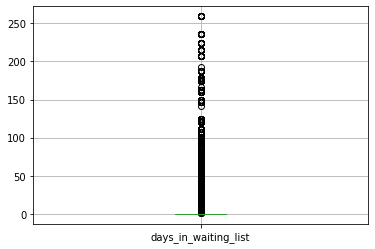

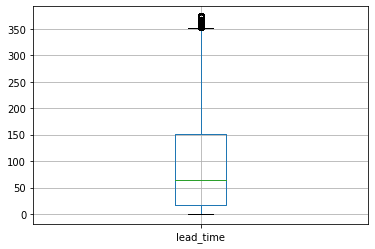

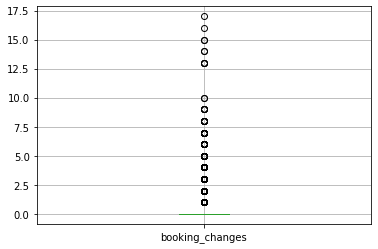

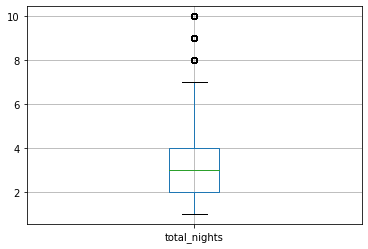

In [7]:
plot_f(hotel_train, 'days_in_waiting_list')
plot_f(hotel_train, 'lead_time')
plot_f(hotel_train, 'booking_changes')
plot_f(hotel_train, 'total_nights')

In [8]:
print(hotel_train['days_in_waiting_list'].describe()) #распределение данных по столбцам, в которых ожидаемо могут быть выбросы
hotel_train['lead_time'].describe()

count    65229.000000
mean         3.334422
std         18.239606
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        259.000000
Name: days_in_waiting_list, dtype: float64


count    65229.000000
mean        96.337917
std         96.127545
min          0.000000
25%         17.000000
50%         64.000000
75%        151.000000
max        374.000000
Name: lead_time, dtype: float64

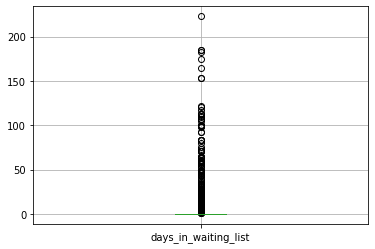

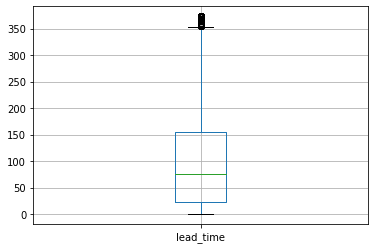

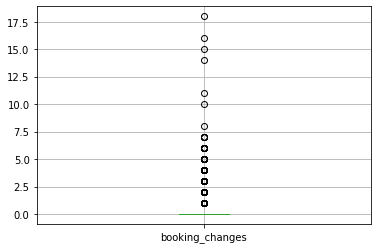

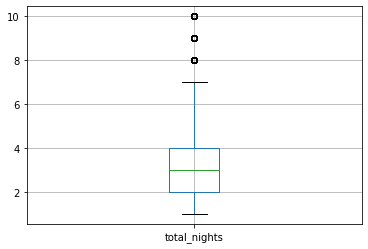

In [9]:
plot_f(hotel_test, 'days_in_waiting_list')
plot_f(hotel_test, 'lead_time')
plot_f(hotel_test, 'booking_changes')
plot_f(hotel_test, 'total_nights')

In [10]:
print(hotel_test['days_in_waiting_list'].describe()) #распределение данных по столбцам, в которых ожидаемо могут быть выбросы
hotel_test['lead_time'].describe()

count    32412.000000
mean         0.262341
std          4.733027
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        223.000000
Name: days_in_waiting_list, dtype: float64


count    32412.000000
mean        97.587869
std         86.507146
min          0.000000
25%         23.000000
50%         76.000000
75%        155.000000
max        373.000000
Name: lead_time, dtype: float64

In [11]:
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.rstrip() #уберем лишние пробелы
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.rstrip()

In [12]:
hotel_train['meal'] = hotel_train['meal'].str.rstrip() #уберем лишние пробелы
hotel_test['meal'] = hotel_test['meal'].str.rstrip()

In [13]:
hotel_train = hotel_train.query('adults!=0') 
#без взрослых номер забронировать невозможно, поэтому уберем из обучающих данных такие строки

In [14]:
def remove_extra_data(data, columns): #фуекция для удаления лишних данных
    for column in columns:
        q25 = data[column].quantile(0.25)
        q75 = data[column].quantile(0.75)

        first_part = q25-1.5*(q75-q25)
        second_part = q75+1.5*(q75-q25)

        data =  data[data[column] <= second_part]
        data = data[data[column] >= first_part]

    data = data.reset_index(drop = True)
    return data

In [15]:
hotel_train = remove_extra_data(hotel_train, ['lead_time', 'days_in_waiting_list'])

In [16]:
hotel_train_corr = hotel_train.drop(['id', 'is_repeated_guest', 'required_car_parking_spaces',
                                     'customer_type', 'country', 'distribution_channel',
                                     'is_canceled', 'reserved_room_type', 'meal'], axis=1) 
#создадим временную переменную без бинарных и категориальных фичей для исследования корреляции

<AxesSubplot:>

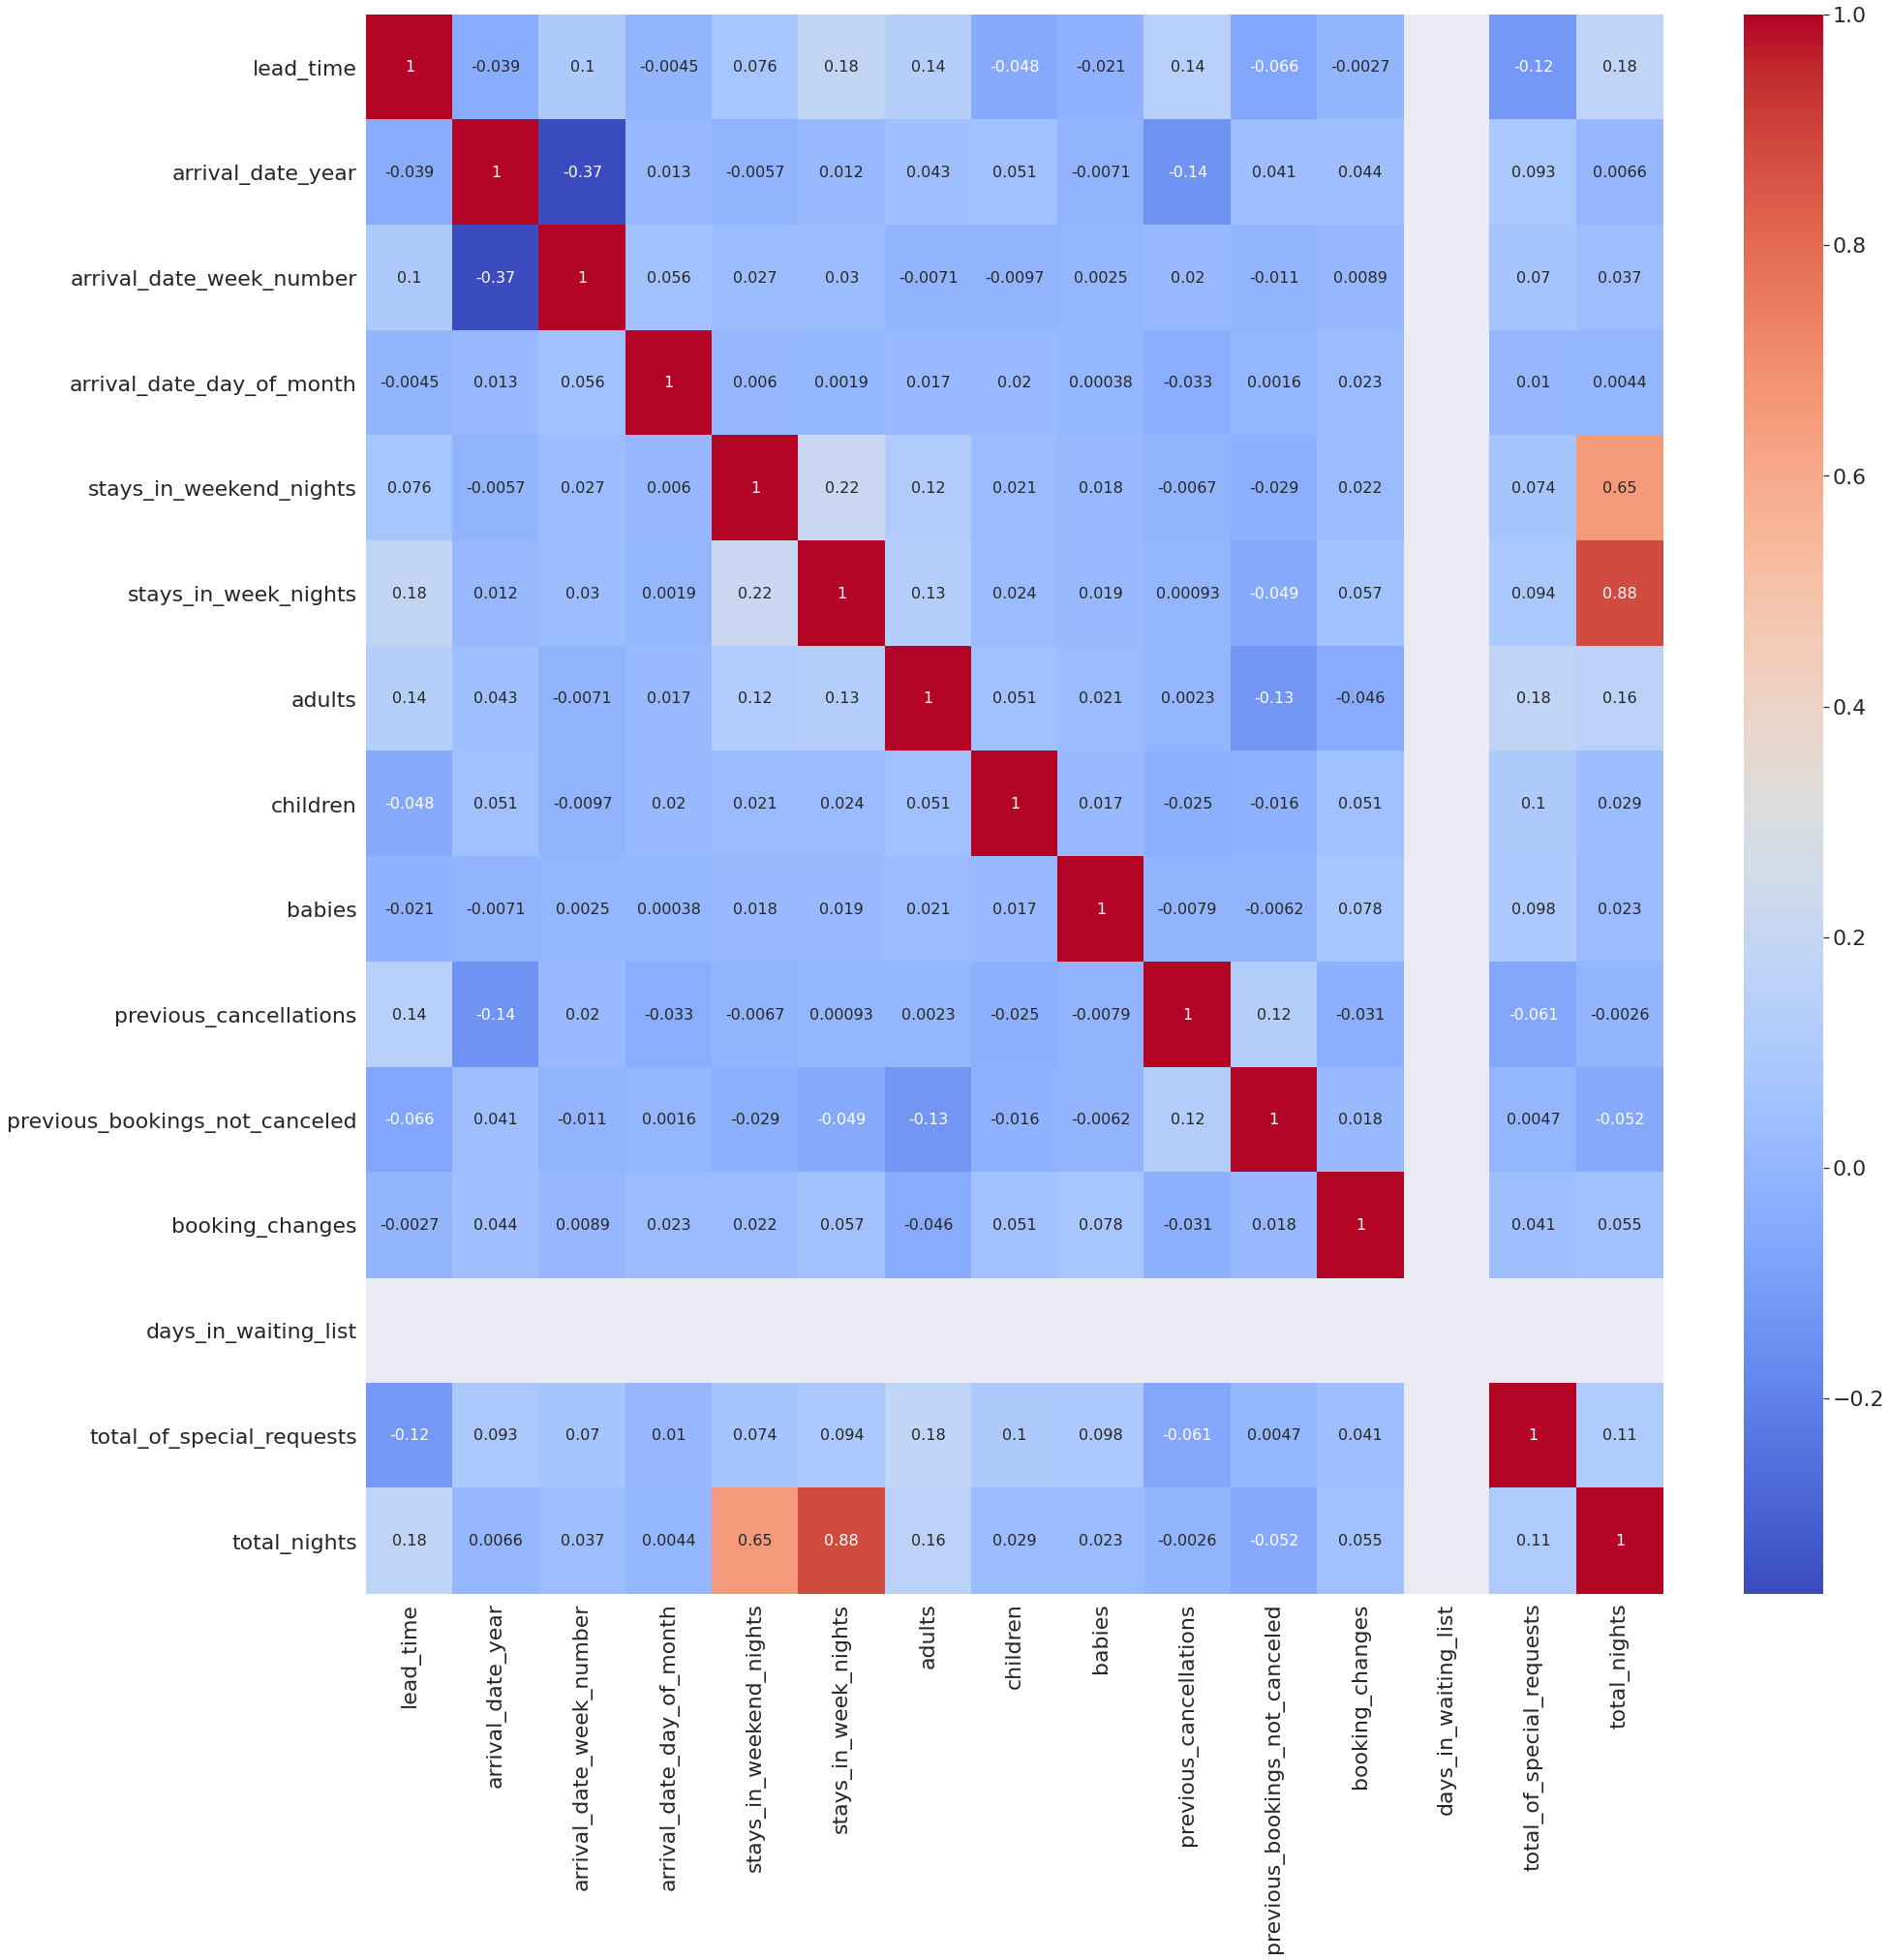

In [17]:
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)
sns.heatmap(hotel_train_corr.corr(), annot = True, fmt='.2g', cmap= 'coolwarm', annot_kws={"fontsize":16}) 
#визуализация корреляции с помощью библиотеки seaborn

In [18]:
hotel_train['is_canceled'].value_counts() 
#таргет проверку на сбалансированность не прошел, не отмененных заказов в в 2 раза больше

0    39871
1    21475
Name: is_canceled, dtype: int64

**Вывод:** в данных не было дублей, пропусков, все исправно открывается. Наблюдались выбросы данных, которые были удалены с наименьшими потерями для выборок с целью получения более точных расчетов на моделях. Заменила написание типов комнат и типов питания. Прослеживается корреляция между двумя признаками.

### Формулировка ML-задачи на основе бизнес-задачи

In [19]:
def day_in_month(month): #функиця для определения количества дней в месяце
    if month == 2:
        return(28)
    elif (month < 8 and month % 2 == 0) or (month > 7 and month % 2 != 0):
        return(30)
    else:
        return(31)

In [20]:
def season(month): #функция для определения сезона, чтобы в дальнейшем определить сезонную наценку на номер
    if month in [3, 4, 5, 9, 10, 11]:
        return 'Spring_Autumn'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [12, 1, 2]:
        return 'Winter'

In [21]:
PRICE_PER_ROOM_TYPE = {'A': [1000, 400], 'B' : [800, 250], 'C': [600, 350], 
                       'D': [550, 150], 'E': [500, 150], 'F': [450, 150], 'G': [450, 150]}
PRICE_PER_SEASON = {'Spring_Autumn': 1.2, 'Summer': 1.4, 'Winter': 1.0}
MONTH = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 
         'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12} 
def profit_without_deposit(date, month, nights, room_type, canceled = 0): 
    #функция для определения прибыли без внедрения депозита
    if canceled:
        return 0
    else:
        month = MONTH[month]
        profit = 0
        if nights == 1:
            washes = 1
        else:
            washes = nights // 2 #расчет стоимость расходов за уборку номера
        profit = - (PRICE_PER_ROOM_TYPE[room_type][1] * washes)
        n_w = 0
        n_s = 0
        n_as = 0
        while(nights):
            if ("Winter" == season(month)):
                n_w = n_w + 1
            elif ("Summer" == season(month)):
                n_s = n_s + 1
            else :
                n_as = n_as + 1

            if (day_in_month(month) == date):
                if month == 12:
                    month == 1
                else:
                    month = month + 1
                date = 1
            else:
                date = date + 1
            nights = nights - 1

        profit += PRICE_PER_ROOM_TYPE[room_type][0]*(n_w*1 + n_s*1.4 + n_as*1.2)
        return profit

In [22]:
profit_without_deposit_train = hotel_train.apply(lambda x: profit_without_deposit(x['arrival_date_day_of_month'],
                                                                                  x['arrival_date_month'], x['total_nights'],
                                                                                  x['reserved_room_type'], x['is_canceled']),
                                                 axis=1)
profit_without_deposit_train.sum() 

108966770.0

In [23]:
profit_without_deposit_test = hotel_test.apply(lambda x: profit_without_deposit(x['arrival_date_day_of_month'],
                                                                                x['arrival_date_month'], x['total_nights'],
                                                                                x['reserved_room_type'], x['is_canceled']), 
                                               axis=1)
profit_without_deposit_test.sum()

55870370.0

### Разработка модели ML

In [24]:
x_train = hotel_train.drop(['is_canceled', 'id', 'distribution_channel', 'total_nights', 
                             'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 
                             'arrival_date_month'], axis=1)
y_train = hotel_train['is_canceled']
x_test = hotel_test.drop(['is_canceled', 'id', 'distribution_channel', 'total_nights', 
                             'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 
                             'arrival_date_month'], axis=1)
y_test = hotel_test['is_canceled']
#делим данные на таргет и признаки

In [25]:
OHE = OneHotEncoder(handle_unknown='ignore')
OHE.fit(x_train)
x_train = OHE.transform(x_train) 
x_test = OHE.transform(x_test)
#изменим категориальные данные на численные с помощью OneHotEncoder

In [26]:
%%time
best_result_DTC = 0
best_depth_DTC= 0
best_features_DTC = 0
for depth in range (1, 5):
    for features in range(1,10): #определям наилучшие значения гипрепараметров для модели решающего дерева
        model_DTC =  DecisionTreeClassifier(random_state=12345, max_depth=depth, max_features=features, 
                                            class_weight = 'balanced')
        model_DTC.fit(x_train, y_train)
        scores = cross_val_score(model_DTC, x_train, y_train, scoring='f1')
        final_croos_score = sum(scores) / len(scores)
        if final_croos_score > best_result_DTC:
            best_result_DTC = final_croos_score
            best_features_DTC = features
            best_depth_DTC = depth
        
print("наилучшая глубина", best_depth_DTC, 'наилучшее количество признаков', best_features_DTC, 
      "наилучшая точность при этом", best_result_DTC)

наилучшая глубина 4 наилучшее количество признаков 7 наилучшая точность при этом 0.5481950760649863
CPU times: user 6.72 s, sys: 31.7 ms, total: 6.75 s
Wall time: 6.76 s


In [27]:
%%time
best_result_RFC = 0
best_depth_RFC = 0
best_estimators_RFC = 0
for depth in range(1, 5):  #определям наилучшие значения гипрепараметров для модели рандомного дерева
    for est in range (1, 5):
        model_RFC = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight = 'balanced')
        model_RFC.fit(x_train, y_train)
        scores = cross_val_score(model_RFC, x_train, y_train, scoring='f1')
        final_croos_score = sum(scores) / len(scores)
        if final_croos_score > best_result_RFC:
            best_result_RFC = final_croos_score
            best_estimators_RFC = est
            best_depth_RFC = depth

print("точность наилучшей модели на тренировочной выборке:", best_result_RFC, "Лучшее количество деревьев",
      best_estimators_RFC, 'Лучшая глубина дерева:', best_depth_RFC)

точность наилучшей модели на тренировочной выборке: 0.6192431284060556 Лучшее количество деревьев 4 Лучшая глубина дерева: 2
CPU times: user 4.89 s, sys: 20.7 ms, total: 4.91 s
Wall time: 4.93 s


F1-величина: 0.6197084548104956
AUC-ROC величина 0.7343896385877333


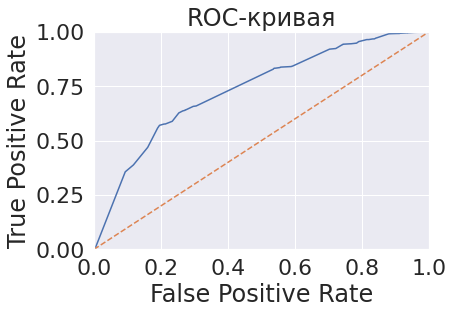

In [28]:
predictions_test = model_RFC.predict(x_test)
f1 = f1_score(y_test, predictions_test)
probabilities_valid = model_RFC.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_valid) #расчет метрик для выбранной модели
print('F1-величина:', f1)
print('AUC-ROC величина', auc_roc)

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr) 

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая")

plt.show()

In [29]:
def deposit(room_type, month): #функция расчета депозита
    n_w = 0
    n_s = 0
    n_as = 0
    if ("Winter" == season(month)):
        n_w = n_w + 1
    elif ("Summer" == season(month)):
        n_s = n_s + 1
    else :
        n_as = n_as + 1
    deposit_room = (PRICE_PER_ROOM_TYPE[room_type][0] * 0.8 * (n_w*1 + n_s*1.4 + n_as*1.2)) + (PRICE_PER_ROOM_TYPE[room_type][1])
    return deposit_room

In [30]:
def profit_with_deposit(date, month, nights, room_type, canceled = 0, pred_canceled = 1): 
    #функция для рассчета прибыли при внедрении депозита
    if canceled == 0:
        return(profit_without_deposit(date, month, nights, room_type))
    elif(pred_canceled == 1):
        return (deposit(room_type, month))
    else:
        return 0

In [31]:
list_1 = [] #расчет прибыли по тестовой выборке
for i in range(len(predictions_test)):
    list_1.append(profit_with_deposit(hotel_test['arrival_date_day_of_month'][i], hotel_test['arrival_date_month'][i], 
                                      hotel_test['total_nights'][i], hotel_test['reserved_room_type'][i], 
                                      hotel_test['is_canceled'][i], predictions_test[i]))
sum(list_1)    

65552524.0

In [32]:
BUDGET=400000 #константная величина заявленного бюджета на разработку модели для бизнеса

In [33]:
sum(list_1) - BUDGET

65152524.0

**Вывод:** прибыль при внедрении модели машинного обучения с учетом затрат на разработку составляет 66.8 миллиона, без модели, и соответственно введения депозита, прибыль составляла 66.4 млн.

### Описание портрета «ненадёжного» клиента

In [34]:
hotel_test.query('is_canceled==1').describe() #визуализируем с помощью метода describe данные по всем, кто отменил бронь

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,12591.000000,12591.0,12591.000000,12591.0,12591.000000,12591.000000,12591.000000,12591.000000,12591.000000,12591.000000,12591.000000,12591.000000,12591.000000,12591.000000,12591.000000,12591.000000,12591.0,12591.000000,12591.000000
mean,42840.515368,1.0,123.511318,2017.0,18.233897,15.558335,0.865459,2.421809,1.905965,0.089270,0.001827,0.003892,0.004130,0.017393,0.106028,0.371376,0.0,0.430228,3.287269
std,16426.229085,0.0,87.531177,0.0,8.741155,8.736541,0.858638,1.316082,0.458670,0.361321,0.042703,0.062264,0.092527,0.432330,0.463904,5.199403,0.0,0.706851,1.635438
min,6086.000000,1.0,0.000000,2017.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000
25%,45869.500000,1.0,52.000000,2017.0,12.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000
50%,49017.000000,1.0,111.000000,2017.0,18.000000,15.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.000000
75%,52164.500000,1.0,177.000000,2017.0,25.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,4.000000
max,96165.000000,1.0,373.000000,2017.0,35.000000,31.000000,4.000000,6.000000,4.000000,3.000000,1.000000,1.000000,4.000000,26.000000,6.000000,183.000000,0.0,5.000000,10.000000


In [35]:
hotel_test.query('is_canceled==1')['customer_type'].value_counts(normalize=True) 
#информация по отменившим какой у них был канал оформления брони

Transient          0.937574
Transient-Party    0.058216
Contract           0.003574
Group              0.000635
Name: customer_type, dtype: float64

In [36]:
hotel_test.query('is_canceled==1')['meal'].value_counts(normalize=True) 
#информация по отменившим какой был тип питания выбран

BB    0.773489
SC    0.162100
HB    0.063299
FB    0.001112
Name: meal, dtype: float64

In [37]:
hotel_test.query('is_canceled==1')['reserved_room_type'].value_counts(normalize=True) 
#информация по отменившим какой был выбран тип номера

A    0.750933
D    0.169327
E    0.043920
F    0.013025
G    0.009134
C    0.007069
B    0.006592
Name: reserved_room_type, dtype: float64

In [38]:
hotel_test.query('is_canceled==1')['arrival_date_month'].value_counts(normalize=True) 
#информация по отменившим в какой месяц они заезжали

May         0.183861
April       0.172584
June        0.163053
March       0.112064
July        0.105710
February    0.090144
August      0.087523
January     0.085061
Name: arrival_date_month, dtype: float64

In [39]:
hotel_test.query('is_canceled==1')['lead_time'].value_counts(normalize=True) 
#информация по отменившим за сколько до заезда была произведена бронь

56.0     0.014058
28.0     0.013819
38.0     0.012390
175.0    0.009372
156.0    0.009292
           ...   
365.0    0.000159
366.0    0.000079
347.0    0.000079
343.0    0.000079
349.0    0.000079
Name: lead_time, Length: 364, dtype: float64

In [40]:
hotel_test.query('is_canceled==1')['country'].value_counts(normalize=True) 
#информация по отменившим из какой они страны

PRT    0.468033
GBR    0.084902
FRA    0.068064
ESP    0.048765
DEU    0.045509
         ...   
AND    0.000079
JEY    0.000079
SYC    0.000079
CIV    0.000079
ISL    0.000079
Name: country, Length: 105, dtype: float64

### Общий вывод

- Модель, которая решает задачу бизнеса с наибольшей выгодой: DecisionTreeClassifier, ее точность составила 0,73.
- Рекомендации для бизнеса:следует вводить депозит для следующих категорий лиц:
 - сделавшие заказ за 2 месяца или ровно за месяц до заселения от момента бронирования на сайте;
 - заказ, оформленный на 2-3 дня, с преобладанием рабочих дней;
 - заказ оформлен на взрослых, преимущественно двух персон, без детей;
 - те, кто оформлял заказ не с группой, то есть обычные отдыхающие;
 - при этом люди бронирующие самый высокий класс номера, но включающий чаще всего завтрак;
 - чаще всего отмены происходили с апреля по июнь;
 - значительная часть отмены пришлась на отдыхающих из Польши.
